# Time series forecasting with LSTM

In this notebook we' ll try use the LSTM networks to make forecast predictions on time series data. The relevant file should be kept at location "./data/data.csv" which is located in "data" directory placed in parallel to this note book.

The data used for this excersie is pricing data for a rental property captured for the period between 2016 - 2019. We are expected to predict the rental value of property for time value looking data the pricing history from past.

In [1]:
# Here are all the prequisite dependencies, Tensorflow Version = 2.0

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
# Lets start by loading the data

rawData = pd.read_csv("./data/data.csv")
rawData.describe()   

,house_pk,agency_id,price,dis_water_real,dis_shopping,no_bedrooms,max_persons,house_size,land_size,build_year,renovation_year,apartment,indoor_pool,spa,internet,pets_allowed,water_view,fire_stove,agency_rating
count,85195.000000,85195.00000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.00000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000,85195.000000
mean,88420.225412,120.94698,560.170879,2.442597,1.445012,2.503668,6.380985,84.346511,1264.297189,1984.95137,2004.836563,0.166195,0.033922,0.531616,0.803099,0.543647,0.170022,0.659405,3.748366
std,23073.445439,26.24260,312.439706,7.398710,1.691833,0.881968,1.844330,41.507354,1336.333740,33.81816,7.977483,0.372258,0.181030,0.499002,0.397659,0.498094,0.375654,0.473912,0.803859
min,1108.000000,90.00000,28.000000,0.000000,0.001000,1.000000,4.000000,25.000000,0.000000,1814.00000,1982.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,85799.000000,90.00000,336.000000,0.441000,0.400000,2.000000,6.000000,58.000000,130.000000,1980.00000,2002.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
50%,91750.000000,121.00000,455.000000,0.810000,0.800000,3.000000,6.000000,82.000000,1100.000000,1990.00000,2006.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
75%,99669.000000,130.00000,700.000000,1.493000,2.000000,3.000000,7.000000,106.000000,2138.000000,2005.00000,2010.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,116663.000000,160.00000,2688.000000,45.559000,10.000000,5.000000,16.000000,216.000000,10000.000000,2015.00000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [9]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85195 entries, 0 to 85194
Data columns (total 20 columns):
house_pk           85195 non-null int64
agency_id          85195 non-null int64
date_in            85195 non-null object
price              85195 non-null int64
dis_water_real     85195 non-null float64
dis_shopping       85195 non-null float64
no_bedrooms        85195 non-null int64
max_persons        85195 non-null int64
house_size         85195 non-null int64
land_size          85195 non-null int64
build_year         85195 non-null int64
renovation_year    85195 non-null int64
apartment          85195 non-null int64
indoor_pool        85195 non-null int64
spa                85195 non-null int64
internet           85195 non-null int64
pets_allowed       85195 non-null int64
water_view         85195 non-null int64
fire_stove         85195 non-null int64
agency_rating      85195 non-null float64
dtypes: float64(3), int64(16), object(1)
memory usage: 13.0+ MB


We can see it's a nicely structured data "house_pk" is the primary key for data and "price" is the target label.


## Data Visualisation

Lets do a dumb plot of the "price" versus "date_in" variables to see what kind of data are we dealing with.

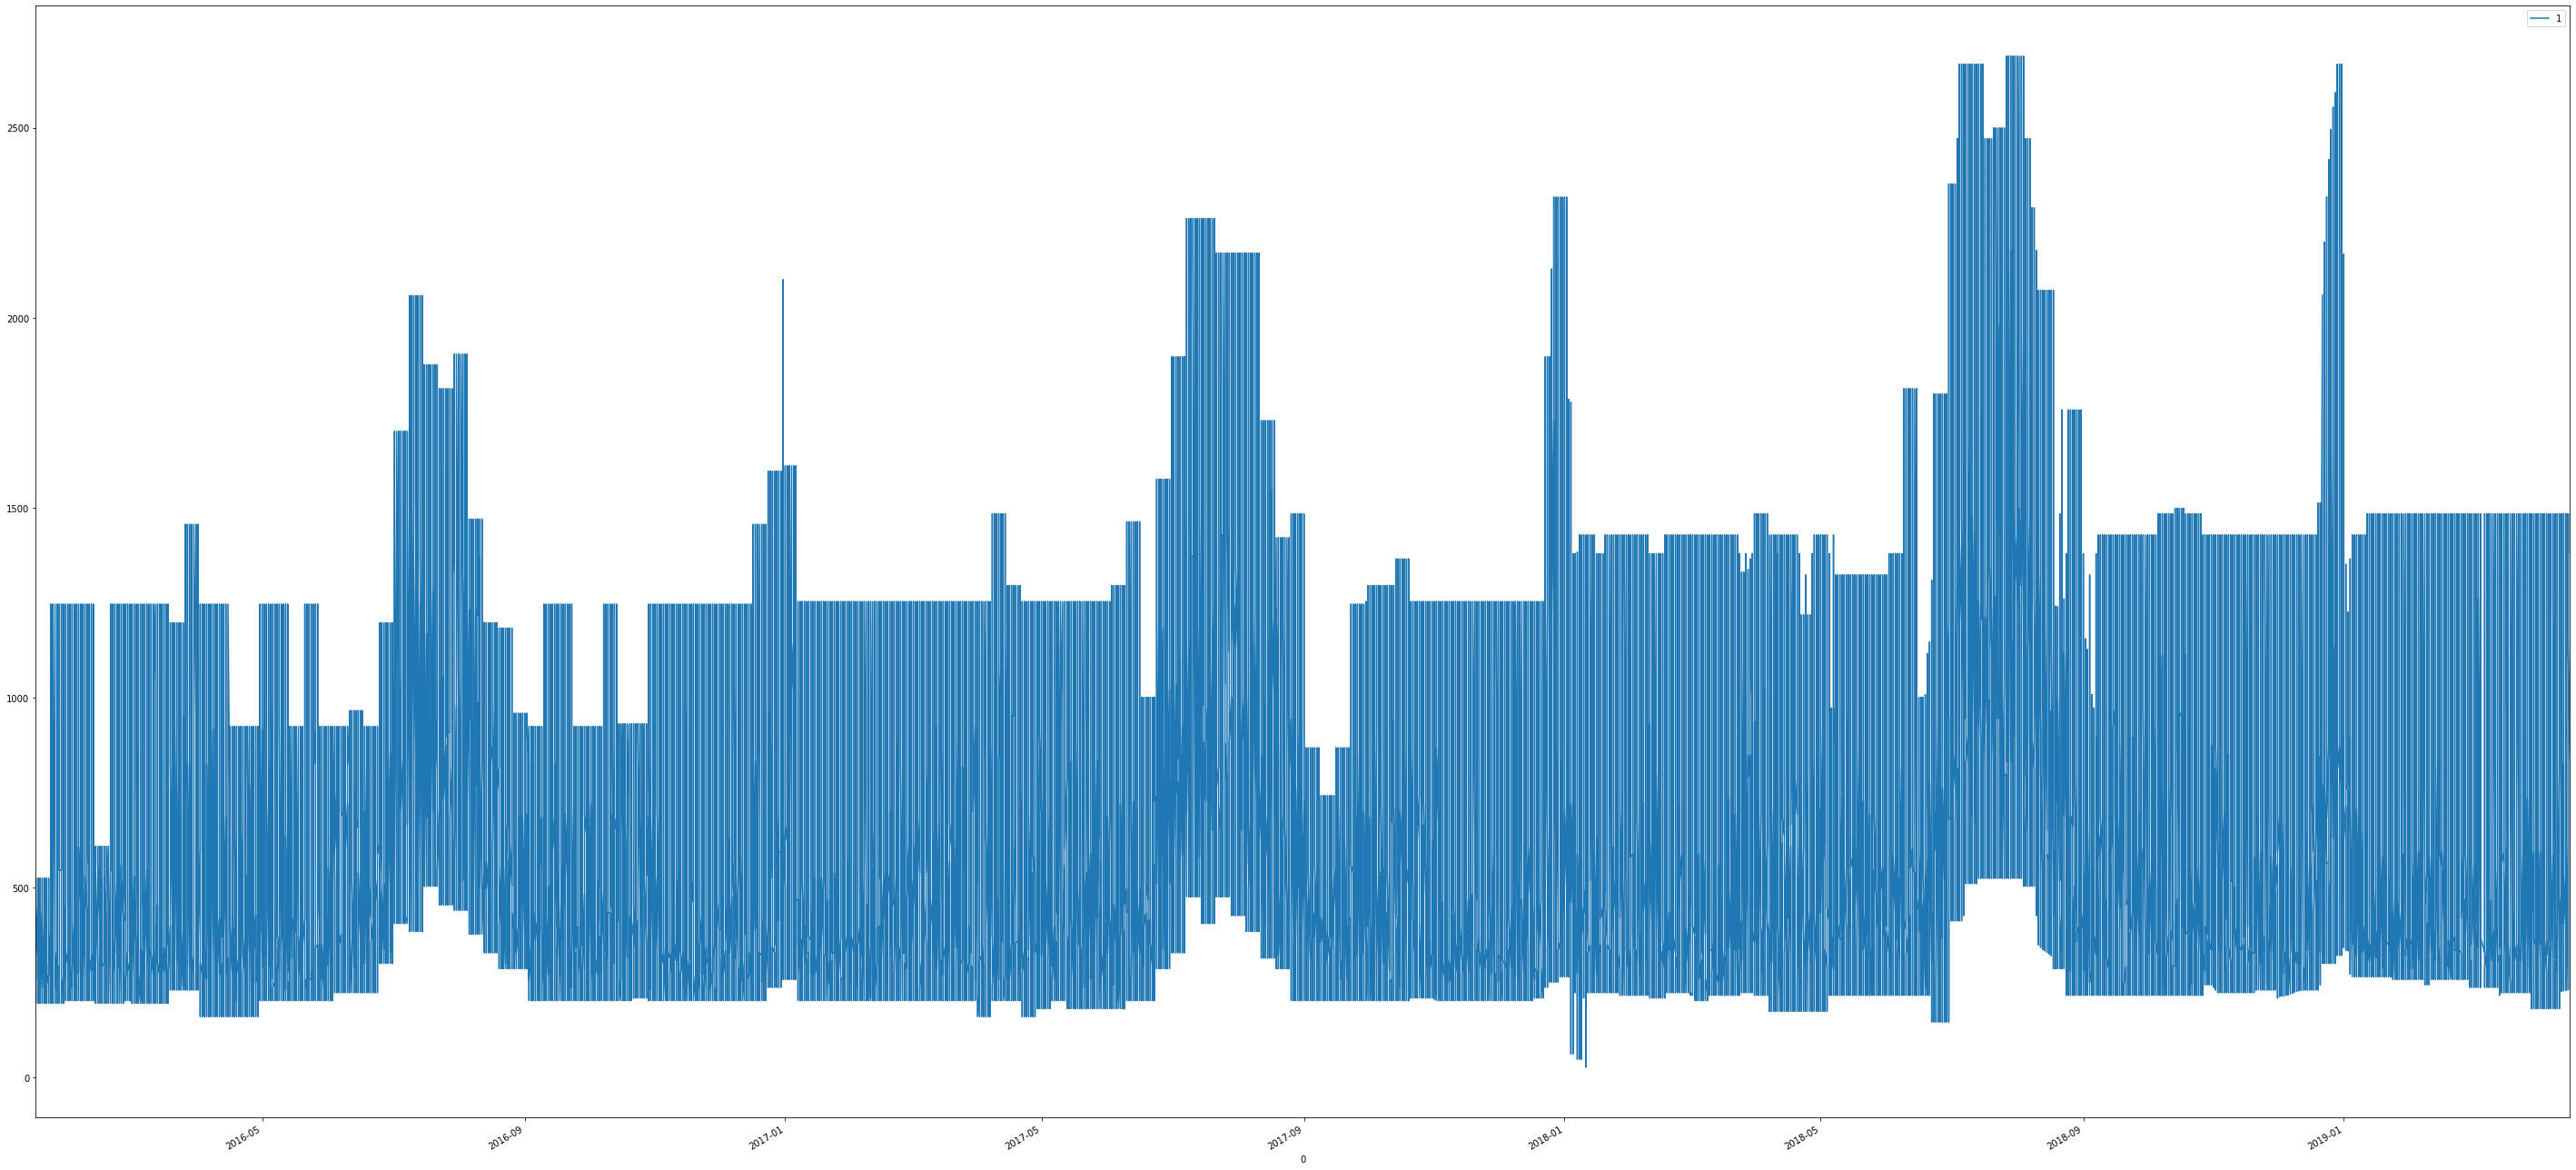

In [15]:
all_ts = pd.to_datetime(rawData['date_in'])
all_price = rawData['price']
all_data = zip(all_ts, all_price)
all_df = pd.DataFrame(all_data)

all_df.plot(x=0, y=1, figsize=(50, 25))

As we can see this is a highly biased data (flat regions) with some spike in prices Aug-Sep period every year (understandally, looks like peak of summer season). Building any kind of forecasting model here with this data will end up in a higly biased model which will forecast "prices" most of the times in flat regions regardless of individual property prices.

We need to look deeper into the data and probably look at the pricing trends for individual proerties
Let's begin with finding unique proeprties in this data.

In [20]:
uniquePKs = rawData['house_pk'].unique()
print(uniquePKs[:10])
print('Unique property count = ' + str(len(uniquePKs)))

[ 84561 115610 116663  92534  84077  87425   7604 101007  87503   7602]
Unique property count = 100


We can notice that we have around 100 unique residential properties. Lets see what kind of pricing distribution each one of those have next.

Following are the steps we going to take here

1. We'll create a utility function to create a mini data frame for each property pricing distribution
2. Next we'll create a dcitnoary pricing data frame of all unique properties indexed by it's 'house_pk' key
3. We'll plot the pricing distribution for each property to see if we can find any trends in pricing data

In [25]:
# Step 1

def getDataFrameForHousePK(house_pk):
    rows_pk = rawData[rawData["house_pk"] == house_pk]
    ts_pk = pd.to_datetime(rows_pk["date_in"])
    price_pk = rows_pk["price"]
    data_pk = zip(ts_pk, price_pk)
    df_pk = pd.DataFrame(data_pk)
    df_pk.columns = ['date_in', 'price']
    df_pk['year'] = df_pk['date_in'].map(lambda t: t.year - 2015)
    df_pk['month'] = df_pk['date_in'].map(lambda t: t.month)
    df_pk['day'] = df_pk['date_in'].map(lambda t: t.day)
    return df_pk

#Step 2

dictPKVsDF = {}
for uKey in uniquePKs:
    dictPKVsDF[uKey] = getDataFrameForHousePK(uKey)

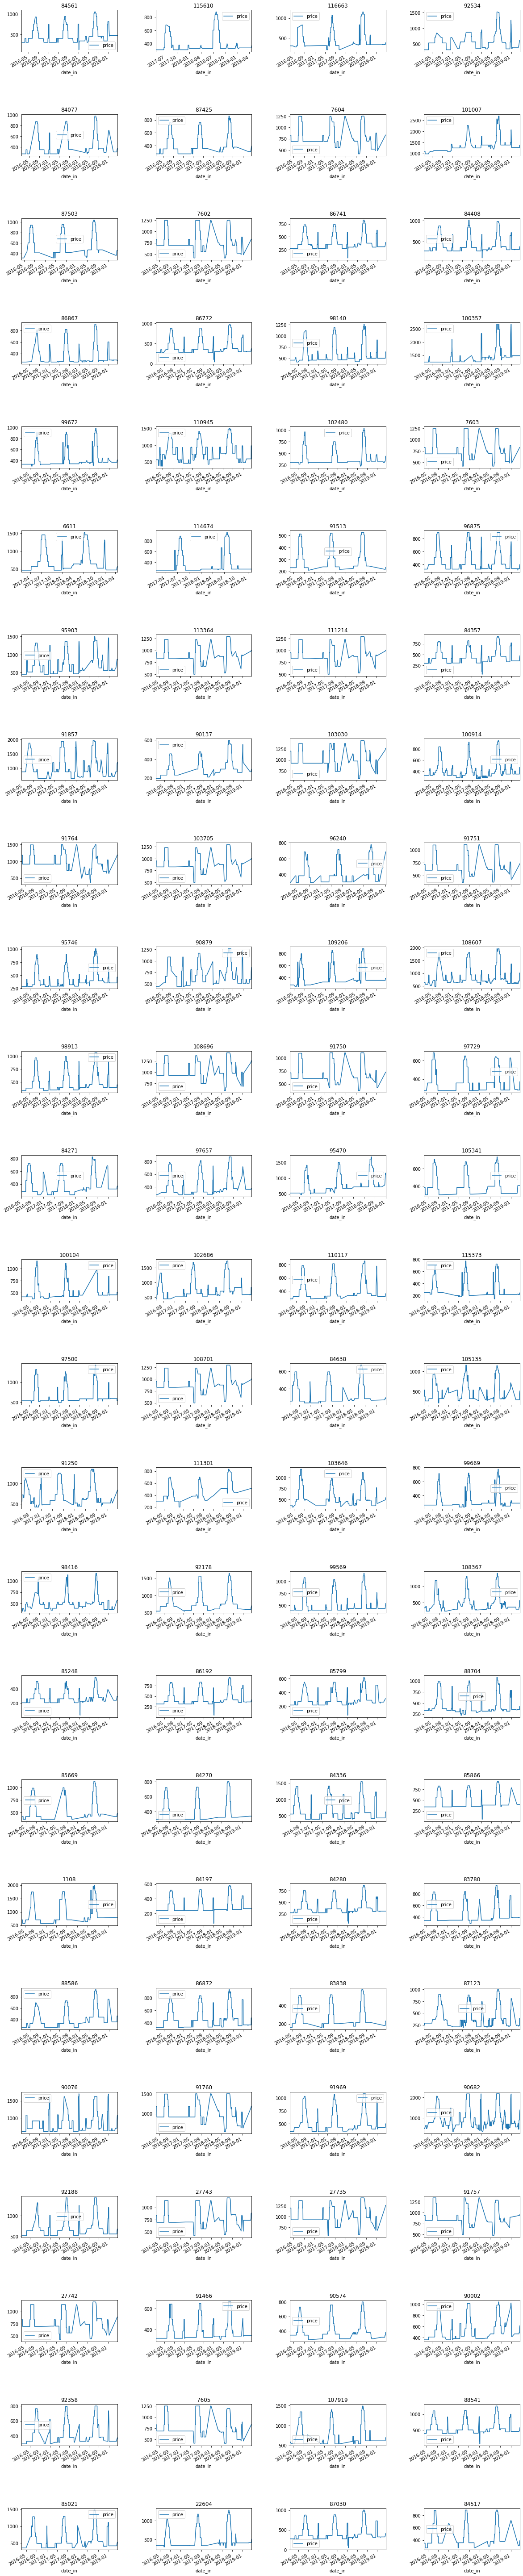

In [24]:
#Step 3

nCols = 4
nRows = 25
iKey = 0

fig, axs = plt.subplots(nRows, nCols,figsize=(20,100))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
for row in np.arange(nRows):
    for col in np.arange(nCols):
        df = dictPKVsDF[uniquePKs[iKey]]
        df.plot(x=0, y=1, ax=axs[row, col])
        axs[row, col].set_title(uniquePKs[iKey])
        iKey +=1;

__This looks nice, we have nice little pricing plots for each property here, clearly showing some kind of time trend in each 1 of them each having differen maximas/minimas.__

## Forecasting model strategy

1. As we notice that pricing dristribution for each property in itself is unique and has categorially different patterns from others

2. Building one large monolithic model to predict the future price of the property might not be a good idea as we risk of loosing the mini data trends residing in each price distribution.

3. We'll go the alternate way of creating one generic LSTM network considering the data of one pricing distribution which can then be re-trained on some other pricing distribution to ouput future prices. In other words the network architechture for all properties will remain same just that we'll train the same arhitecture with unique property data instead of all data

Let's start with 1st property with house_pk = 84561

In [28]:
df = dictPKVsDF[84561]
df = df.sort_values(by='date_in')
df.head()

,date_in,price,year,month,day
151,2016-02-06,301,1,2,6
150,2016-02-07,301,1,2,7
149,2016-02-08,301,1,2,8
148,2016-02-09,301,1,2,9
147,2016-02-10,301,1,2,10


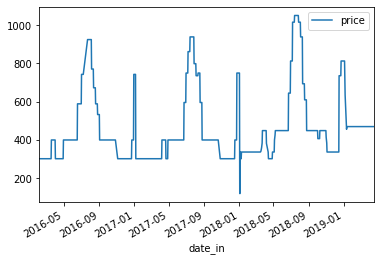

Total number of data points = 1107


In [136]:
df.plot.line(x=0, y=1)
plt.show()
print('Total number of data points = ' + str(len(df)))

### We only have 1107 Data Points (too less)

As we can see above, an observation is recorded every 1 day. This means that, for a single month, we will have roughly 30 observations. Similarly, a single year will contain 360 (12x30) observations.

Given a specific time, let's say we want to predict the price 30 days in the future. In order to make this prediction, we choose to use 1 year of observations. Thus, we would create a window containing the last 360(12x30) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter "history_size" is the size of the past window of information. The "target_size" is how far in the future does the model need to learn to predict. The "target_size" is the label that needs to be predicted.

In [32]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
          labels.append(target[i+target_size])
        else:
          labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

#### Let's normalize our data before generating time windowed training and test data sets

In [33]:
features_considered =  ['price', 'month']
features = df[features_considered]
features.index = df['date_in']
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

#### Training and Validation data sets


In [124]:
past_history = 270              # Looking into past 270 days of data
future_target = 60              # Making pricing pridictions for next 60 days
STEP = 6
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS = 10
EVALUATION_INTERVAL = 200
TRAIN_SPLIT = round(len(dataset) * 0.70)

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [133]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print("Train Data Shape      = " + str(x_train_multi.shape) )
print("Validation Data Shape = " + str(x_val_multi.shape) )

Train Data Shape      = (505, 45, 2)
Validation Data Shape = (2, 45, 2)


#### LSTM Network

In [126]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [127]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 16s 79ms/step - loss: 0.3530 - val_loss: 0.2567
Epoch 2/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1760 - val_loss: 0.1667
Epoch 3/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1428 - val_loss: 0.0978
Epoch 4/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1279 - val_loss: 0.1056
Epoch 5/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1185 - val_loss: 0.0769
Epoch 6/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1127 - val_loss: 0.0808
Epoch 7/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1084 - val_loss: 0.0674
Epoch 8/10
200/200 [==============================] - 12s 62ms/step - loss: 0.1051 - val_loss: 0.0662
Epoch 9/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1024 - val_loss: 0.0666
Epoch 10/10
200/200 [==================

In [108]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

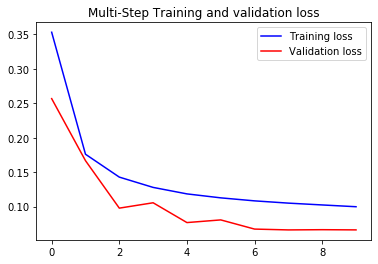

In [128]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Plotting utility to plot True history, True Future and Predicted Future Values


In [65]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def baseline(history):
    return np.mean(history)

### Let's make some predictions on our model with validation data and plot them against their true values

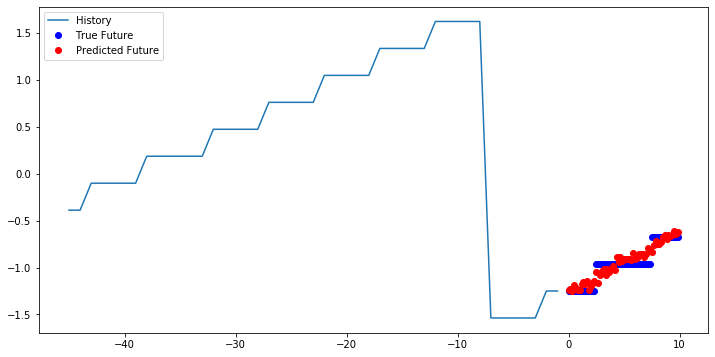

In [135]:
for x, y in val_data_multi.take(1):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

#### As we can see here out model here is doing pretty well in predicting future prices close to their true values. The train and validation accuracies are also decreasing with time indicating we arent overfitting here

#### Following are other noticable points here
#### 1. Our training data is relatively small for deep learing purposes (around 1107 rows).
#### 2. Model is also relatively simple with 2 LSTM and 1 Dense layer only
#### 3. Model is trained for low EPOCH values as we are training it on CPU
#### 4. Same network can be reused for redicting future price of other properties just by changing house_pk values above and retraing it on new property dataset

### Given some more data, more compute GPU power and more time to experiment with more deeper models can possibly improve the model performance